In [4]:
import numpy as np
import pandas as pd
from datetime import datetime

c:\users\andre\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\andre\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748005 entries, 0 to 748004
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   index            748005 non-null  int64         
 1   timestamp        748005 non-null  float64       
 2   price            748005 non-null  float64       
 3   instrument_name  748005 non-null  object        
 4   index_price      748005 non-null  float64       
 5   direction        748005 non-null  object        
 6   amount           748005 non-null  float64       
 7   time_trade       748005 non-null  datetime64[ns]
 8   strike           748005 non-null  int64         
 9   type             748005 non-null  object        
 10  time_create      748005 non-null  datetime64[ns]
 11  time_expire      748005 non-null  datetime64[ns]
 12  date             748005 non-null  datetime64[ns]
 13  irate            748005 non-null  float64       
 14  price_USD        748

<AxesSubplot:>

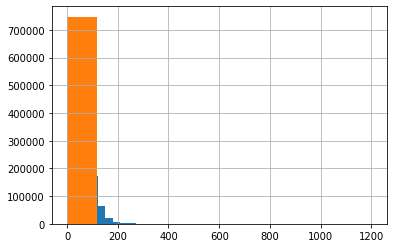

In [5]:
# timestamp: ms passed from epoch
# price: option on 1 BTC price in BTC
# instrument_name: BTC-17FEB17-975-C
# index_price: price of 1 BTC in USD
# direction: sell/buy
# amount: amount of underlying BTC
# time_trade: ...
# strike: strike price in USD
# type: call/put
# time_create: ...
# time_expire: ...
# date: date of trade
# irate: 3m Treasury bill rate
# price_USD: option on 1 BTC price in USD
# iv_Tbill: BS implied volatility according to 3m Treasury Bill
# tt: time to maturity in fractions of a year (365 day)


# C_market: рыночная стоимость колл-опциона на 1 BTC выраженная в USD

df = pd.read_csv('Data/Deribit_w_IV.csv')

# некоторые iv_tbill имеют значение .
df = df[df['iv_Tbill'] != '.']
df['iv_Tbill'] = df['iv_Tbill'].astype(np.float64)
# Выбрасываем безумные значения IV. У всех таких ордеров очень маленькое tt. Откуда такие значения IV и нужно ли их выбрасывать?
df = df[df['iv_Tbill'] <= 300]
# Корректируем типы
df['date'] = pd.to_datetime(df['date'])
df['time_trade'] = pd.to_datetime(df['time_trade'])
df['time_create'] = pd.to_datetime(df['time_create'])
df['time_expire'] = pd.to_datetime(df['time_expire'])

# Переводим стоимости путов в стоимости коллов через пут-колл паритет и помещаем результат в C_market
puts = df[df['type'] == 'put']
calls = df[df['type'] == 'call']

calls['C_market'] = calls['price_USD']
puts['C_market'] = puts['price_USD'] + puts['index_price'] - puts['strike'] * np.exp(-puts['irate'] * puts['tt'])
df = pd.concat([calls, puts]) #[['index_price', 'strike', 'time_expire', 'tt', 'date', 'C_market', 'iv_Tbill', 'irate', 'type']]
df = df.reset_index()

df['iv_Tbill'].hist()
df.info()
df['amount'].hist()

In [164]:
# # Найдем день, в который торговалось больше всего опционов
# max_calls_date = df.date.unique()[0]
# max_calls = 0
# for date in df.date.unique():
#     # Получаем набор торговавшихся опционов и усредняем их параметры
#     data = df[df.date == date]
#     data = data.groupby(['strike', 'time_expire'])[['index_price', 'tt', 'date', 'C_market', 'iv_Tbill', 'irate']].mean()
#     if len(data) > max_calls:
#         max_calls = len(data)
#         max_calls_date = date

# Получаем набор торговавшихся опционов и усредняем их параметры
data = df[df.date == df.iloc[11111].date]
data = data[data['type'] == 'call']
data = data.groupby(['strike', 'time_expire'])[['index_price', 'tt', 'date', 'C_market', 'iv_Tbill', 'irate']].mean()
data = data.reset_index()
data

,strike,time_expire,index_price,tt,C_market,iv_Tbill,irate
0,5500,2017-12-29 08:00:00,6984.950000,0.154223,1640.066260,64.911678,0.01148
1,6000,2017-12-29 08:00:00,7280.328182,0.153210,1487.531207,59.939244,0.01148
2,6500,2017-11-03 08:00:00,7175.790000,0.000390,675.959418,174.330553,0.01148
3,6500,2017-11-10 08:00:00,7295.393571,0.018765,900.908145,97.111106,0.01148
4,6500,2017-11-24 08:00:00,7381.670000,0.057329,1032.698624,69.475131,0.01148
5,6500,2017-12-29 08:00:00,7298.669231,0.152880,1201.723359,67.503758,0.01148
6,6600,2017-11-24 08:00:00,7040.270000,0.058431,633.624300,56.260199,0.01148
7,6750,2017-11-10 08:00:00,7287.410000,0.018607,755.949116,113.965606,0.01148
8,6800,2017-11-03 08:00:00,7001.030000,0.000731,261.138419,185.273976,0.01148
9,7000,2017-11-03 08:00:00,6984.170000,0.000724,127.111894,179.718762,0.01148


In [165]:
data.to_csv('Data/data.csv', index=False)

In [35]:
from scipy.optimize import differential_evolution


def market(x):
    return 3 * x ** 2 - 5


def model(params, x):
    a, b, c = params
    return a * x ** 2 + b * x + c


def obj_func(params, x):
    errors = model(params, x) - market(x)
    return  np.sum(errors ** 2)


x = np.linspace(-10, 10)
bounds = [(-10, 10), (-10, 10), (-10, 10)]
res = differential_evolution(func=obj_func,
                             args=(x,),
                             bounds=bounds)
res.x, res.nfev, res.fun

(array([ 3.,  0., -5.]), 7464, 1.7810112657174784e-26)

Callback for minimizer starting at [0. 0. 0.]:
[2.13074738e+05 9.76562500e-04 3.36938770e+03]
[ 1.70635252e+00 -4.10034359e-05 -4.50785391e+01]
[ 0.99999999  0.00316168 -0.99999966]
[ 9.99999983e-01 -7.45058077e-09 -9.99999435e-01]
[ 9.99999994e-01 -3.13501430e-09 -9.99999687e-01] 2.273373172007508e-12 True
Optimization terminated successfully.


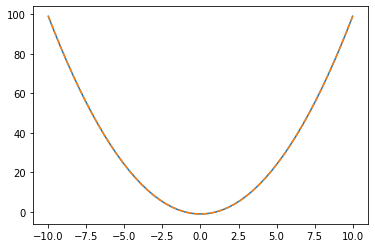

In [132]:
from scipy.optimize import rosen, shgo, differential_evolution
import numpy as np
import matplotlib.pyplot as plt

def func(params, x):
    a, b, c = params
    return a * x ** 2 + b * x + c

def obj_func(params, x, y):
    errors = func(params, x) - y
    return np.sum(errors ** 2)

x = np.linspace(-10, 10)
a, b, c = 1, 0, -1
y = func((a, b, c), x)

bounds = [(None, None), (None, None), (None, None)]
res = shgo(obj_func, bounds, args=(x, y,), callback=print)
# res = differential_evolution(obj_func, bounds, args=(x, y,))

print(res.x, res.fun, res.success)
print(res.message)

plt.plot(x, y)
plt.plot(x, func(res.x, x), '--')
plt.show()